In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
slot_result = pd.read_csv('../data/slot_machine/platinum_csv/pl_all.csv')

In [4]:
slot_result.head()

,img,classname
0,platinum_0_0.jpg,Ca
1,platinum_0_1.jpg,A
2,platinum_0_2.jpg,Q
3,platinum_0_3.jpg,W
4,platinum_0_4.jpg,A


In [9]:
print(len(slot_result), len(slot_result) // 15)

18615 1241


In [8]:
slot_result['classname'].value_counts() / len(slot_result) * 100

Q     13.263497
10    12.613484
K     11.931238
A     11.915122
J      9.395649
Ca     9.331185
Cr     8.740263
D      8.025786
Co     7.751813
R      3.900081
W      3.131883
Name: classname, dtype: float64

In [20]:
slot_result['img'][0].split('_')[1]

['platinum', '0', '0.jpg']

In [31]:
slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(slot_result['img'])]
slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(slot_result['img'])]
slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(slot_result['img'])]

In [58]:
slot_result['game'] = slot_result_game
slot_result['row'] = slot_result_row
slot_result['col'] = slot_result_col

slot_result.head(30)

,img,classname,game,row,col
0,platinum_0_0.jpg,Ca,0,1,1
1,platinum_0_1.jpg,A,0,2,1
2,platinum_0_2.jpg,Q,0,3,1
3,platinum_0_3.jpg,W,0,1,2
4,platinum_0_4.jpg,A,0,2,2
5,platinum_0_5.jpg,A,0,3,2
6,platinum_0_6.jpg,10,0,1,3
7,platinum_0_7.jpg,Cr,0,2,3
8,platinum_0_8.jpg,Co,0,3,3
9,platinum_0_9.jpg,10,0,1,4


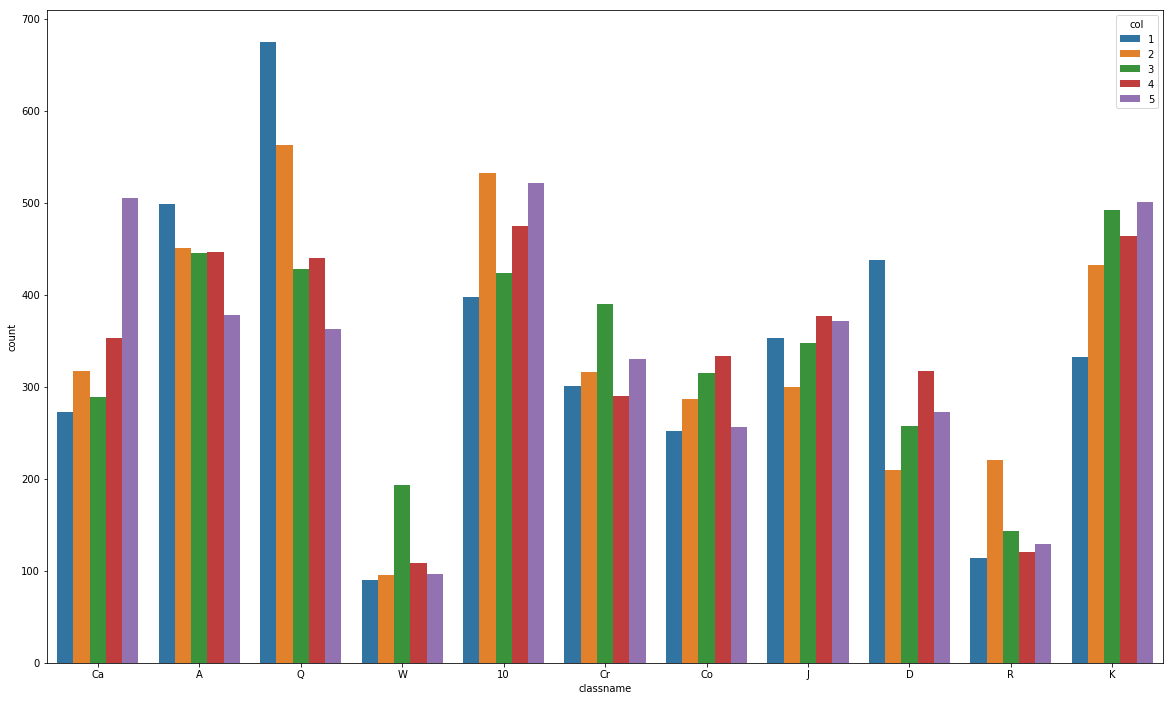

In [51]:
plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=slot_result, hue='col')
plt.show()

In [61]:
slot_result[slot_result['col'] == 1]['classname'].value_counts() / len(slot_result[slot_result['col'] == 1]) * 100

Q     18.130540
A     13.376309
D     11.764706
10    10.663443
J      9.481601
K      8.917540
Cr     8.084878
Ca     7.332796
Co     6.768735
R      3.062047
W      2.417405
Name: classname, dtype: float64

In [68]:
l_1 = []
s = ''
for n, i in enumerate(slot_result[slot_result['col'] == 1]['classname']):
    s += i
    if (n + 1) % 3 == 0:
        l_1.append(s)
        s = ''

In [76]:
l_1.count('CrCrCr')

2

In [75]:
pd.Series(l_1).value_counts()

QQQ       22
AAA       17
QQ10      15
KKK       15
QQK       14
101010    13
JJJ       12
QQCa      12
QQD       11
1010Cr    11
QQCr      11
DDD       11
CaCaCa     9
AQA        9
CoCoCo     9
AACr       8
AQ10       8
QAQ        8
DCrQ       8
AAQ        8
JJQ        7
CaCaD      7
1010J      7
KKCa       7
AAK        7
JQQ        7
QQA        6
DCrCr      6
JJCr       6
QQR        6
          ..
ACaW       1
JWCr       1
Q10Q       1
ADD        1
CrQD       1
RQCr       1
ARJ        1
DAK        1
QDD        1
Q10A       1
DKCo       1
DQJ        1
10CoK      1
QCrJ       1
Cr10Q      1
DJD        1
10AW       1
CrACr      1
CaQR       1
ACaCr      1
KCoD       1
10JCa      1
J1010      1
DCrR       1
CaACo      1
QD10       1
CoCoCa     1
DKCr       1
ARA        1
J10J       1
Length: 445, dtype: int64

In [70]:
l_2 = []
s = ''
for n, i in enumerate(slot_result[slot_result['col'] == 2]['classname']):
    s += i
    if (n + 1) % 3 == 0:
        l_2.append(s)
        s = ''

In [71]:
pd.Series(l_2).value_counts()

QQQ       27
AAA       24
KKK       19
CrQQ      17
JJJ       17
10KK      15
10QQ      14
CaCaCa    13
101010    12
10JJ      12
JCaCa     12
Q1010     11
Ca1010    11
QRR       11
CrKK      10
QJJ       10
CoCoCo    10
QAA        9
QCoCo      9
ACoCo      9
KQQ        8
DDD        8
K10Q       8
ACaCa      8
KCo10      8
10RR       8
QKK        8
CrCoCo     7
KCoCo      7
QCrCr      7
          ..
KKW        1
KJCa       1
ARA        1
QAK        1
JCr10      1
AKCo       1
WR10       1
RKW        1
CoACo      1
CaJ10      1
QQD        1
10ACa      1
CrKR       1
CaACo      1
J10Q       1
CrKA       1
QWW        1
10CaQ      1
W10Q       1
KKCr       1
DCr10      1
KCrK       1
WW10       1
WKR        1
CoKW       1
10QD       1
QCrK       1
QACa       1
CoQA       1
10CaCo     1
Length: 414, dtype: int64